In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import import_ipynb
from helpers import train_and_validate, count_parameters, plot_loss_comparison, plot_test_predictions, compare_mse_loss
import time
import matplotlib.pyplot as plt

importing Jupyter notebook from helpers.ipynb


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
window_size = 24
batch_size = 100
input_size = 1
hidden_size = 100
num_classes = 1
learning_rate = 0.001
epochs = 200
criterion = nn.MSELoss()

In [4]:
def root_mean_squared_error(actual, predicted):
    actual = torch.tensor(actual, dtype=torch.float32)
    predicted = torch.tensor(predicted, dtype=torch.float32)
    
    if actual.shape != predicted.shape:
        raise ValueError("Tensors must have the same shape.")
    
    mse = torch.mean((actual - predicted)**2)
    
    return (mse.item() ** 0.5)

In [5]:
df = pd.read_csv("./data/clean_data.csv")
df = df[:-24]
df.shape

(15955, 5)

In [6]:
df = df[["Date", "P (kW)"]]
train_df = df.iloc[:-24]
test = df.iloc[-24:]

In [7]:
def prepare_dataframe(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'P (kW)(t-{i})'] = df['P (kW)'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [8]:
new_df = prepare_dataframe(train_df, window_size)
new_df = new_df.to_numpy()
new_df

array([[  0.        ,   0.        ,   0.        , ...,  14.75265   ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 127.16308333,
         14.75265   ,   0.        ],
       [ 16.82213636,   0.        ,   0.        , ..., 302.4557    ,
        127.16308333,  14.75265   ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [9]:
new_df.shape

(15907, 25)

In [10]:
X = new_df[:, 1:]
y = new_df[:, 0]

In [11]:
X.shape, y.shape

((15907, 24), (15907,))

In [12]:
split_index = int(len(X) * 0.9)

In [13]:
X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14316, 24), (1591, 24), (14316,), (1591,))

In [14]:
X_train = X_train.reshape((-1, window_size, 1))
X_val = X_val.reshape((-1, window_size, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14316, 24, 1), (1591, 24, 1), (14316, 1), (1591, 1))

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([14316, 24, 1]),
 torch.Size([1591, 24, 1]),
 torch.Size([14316, 1]),
 torch.Size([1591, 1]))

In [16]:
class SolarData(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [17]:
train = SolarData(X_train, y_train)
val = SolarData(X_val, y_val)

In [18]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val, batch_size = batch_size, shuffle = False)

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([100, 24, 1]) torch.Size([100, 1])


## RNN

In [20]:
class RNNNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn_layer = nn.RNN(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, hidden = self.rnn_layer(x)
        out = self.fc(out[:, -1, :])
        return out

In [21]:
rnnnet = RNNNet(input_size, hidden_size, num_classes).to(device)
rnnnet_optimizer = torch.optim.Adam(rnnnet.parameters(), lr = learning_rate)

In [22]:
total_rnnnet_parameters = count_parameters(rnnnet)

In [23]:
rnnnet_train_loss_array = []
rnnnet_val_loss_array = []

In [24]:
rnnnet_start_time = time.time()
train_and_validate(epochs, device, rnnnet, train_loader, val_loader, criterion, rnnnet_optimizer, rnnnet_train_loss_array, rnnnet_val_loss_array)
rnnnet_end_time = time.time()
rnnnet_total_training_time = rnnnet_end_time - rnnnet_start_time
rnnnet_avg_training_time_per_epoch = rnnnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 84413.98391384548 | Validation Loss: 25575.780303955078
Epoch no.: 2 | Training Loss: 79929.52788628472 | Validation Loss: 23737.97265625
Epoch no.: 3 | Training Loss: 75431.53293185764 | Validation Loss: 22028.117767333984
Epoch no.: 4 | Training Loss: 71648.88883463542 | Validation Loss: 20474.215042114258
Epoch no.: 5 | Training Loss: 67817.37443033855 | Validation Loss: 19082.639572143555
Epoch no.: 6 | Training Loss: 64347.956787109375 | Validation Loss: 17828.353973388672
Epoch no.: 7 | Training Loss: 61482.643717447914 | Validation Loss: 16676.721237182617
Epoch no.: 8 | Training Loss: 58115.824679904516 | Validation Loss: 15660.714080810547
Epoch no.: 9 | Training Loss: 55419.05206976997 | Validation Loss: 14718.492294311523
Epoch no.: 10 | Training Loss: 52732.85232204861 | Validation Loss: 13905.9013671875
Epoch no.: 11 | Training Loss: 50246.33648003472 | Validation Loss: 13200.232116699219
Epoch no.: 12 | Training Loss: 47956.85214572483 | Vali

In [25]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     RNN: {total_rnnnet_parameters}")
print()
print(f"Total Training Time:     RNN: {rnnnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     RNN: {rnnnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     RNN: 10401

Total Training Time:     RNN: 132.92s

Average Training Time Per Epoch:     RNN: 0.66s
------------------------------------------------------------


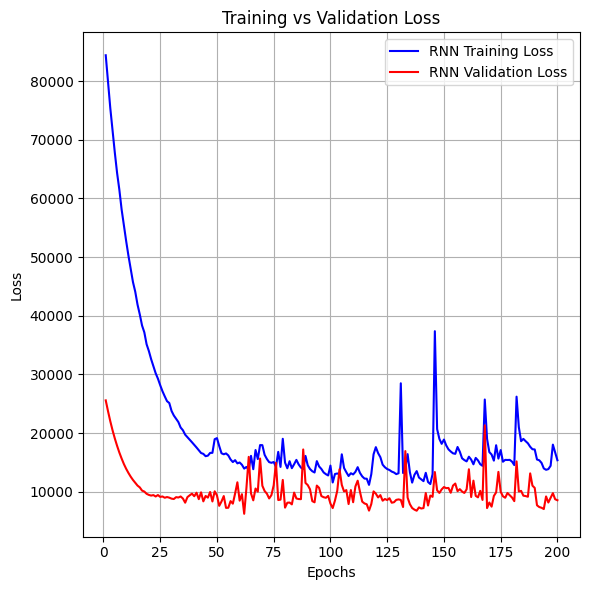

In [26]:
plot_loss_comparison(epochs, rnnnet_train_loss_array, rnnnet_val_loss_array, "RNN Training Loss", "RNN Validation Loss", "Training vs Validation Loss")

In [27]:
rnnnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = rnnnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_3436\1549511991.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


In [28]:
window_size

24

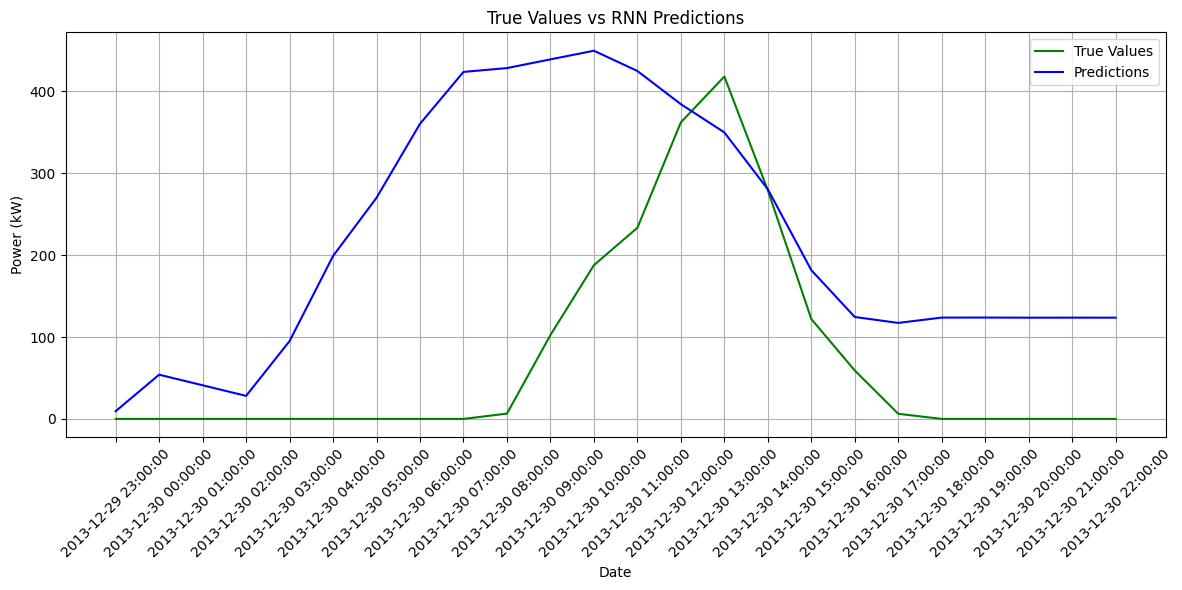

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs RNN Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 197.39943048613387


## LSTM

In [31]:
class LSTMNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, (h_t, c_t) = self.lstm(x)
        out = self.fc(x_[:, -1, :])
        return out

In [32]:
lstmnet = LSTMNet(input_size, hidden_size, num_classes).to(device)
lstmnet_optimizer = torch.optim.Adam(lstmnet.parameters(), lr = learning_rate)

In [33]:
total_lstmnet_parameters = count_parameters(lstmnet)

In [34]:
lstmnet_train_loss_array = []
lstmnet_val_loss_array = []

In [35]:
lstmnet_start_time = time.time()
train_and_validate(epochs, device, lstmnet, train_loader, val_loader, criterion, lstmnet_optimizer, lstmnet_train_loss_array, lstmnet_val_loss_array)
lstmnet_end_time = time.time()
lstmnet_total_training_time = lstmnet_end_time - lstmnet_start_time
lstmnet_avg_training_time_per_epoch = lstmnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 84276.64507378472 | Validation Loss: 25409.681701660156
Epoch no.: 2 | Training Loss: 79256.25355360244 | Validation Loss: 23481.333740234375
Epoch no.: 3 | Training Loss: 74615.86322699653 | Validation Loss: 21730.64776611328
Epoch no.: 4 | Training Loss: 70336.00276692708 | Validation Loss: 20075.264938354492
Epoch no.: 5 | Training Loss: 66497.75607638889 | Validation Loss: 18252.011337280273
Epoch no.: 6 | Training Loss: 62727.838623046875 | Validation Loss: 16543.0265045166
Epoch no.: 7 | Training Loss: 58892.968994140625 | Validation Loss: 14976.349884033203
Epoch no.: 8 | Training Loss: 55536.77992078993 | Validation Loss: 13690.244857788086
Epoch no.: 9 | Training Loss: 52251.301161024305 | Validation Loss: 12731.007873535156
Epoch no.: 10 | Training Loss: 49375.58238389757 | Validation Loss: 11338.287063598633
Epoch no.: 11 | Training Loss: 46308.00141059028 | Validation Loss: 10777.780197143555
Epoch no.: 12 | Training Loss: 43922.29257541233 | V

In [36]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     LSTM: {total_lstmnet_parameters}")
print()
print(f"Total Training Time:     LSTM: {lstmnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     LSTM: {lstmnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     LSTM: 41301

Total Training Time:     LSTM: 209.49s

Average Training Time Per Epoch:     LSTM: 1.05s
------------------------------------------------------------


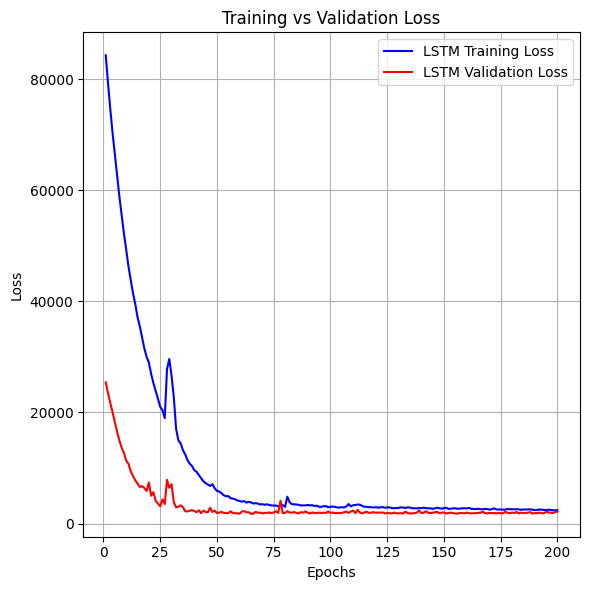

In [37]:
plot_loss_comparison(epochs, lstmnet_train_loss_array, lstmnet_val_loss_array, "LSTM Training Loss", "LSTM Validation Loss", "Training vs Validation Loss")

In [38]:
lstmnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = lstmnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_3436\22171312.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


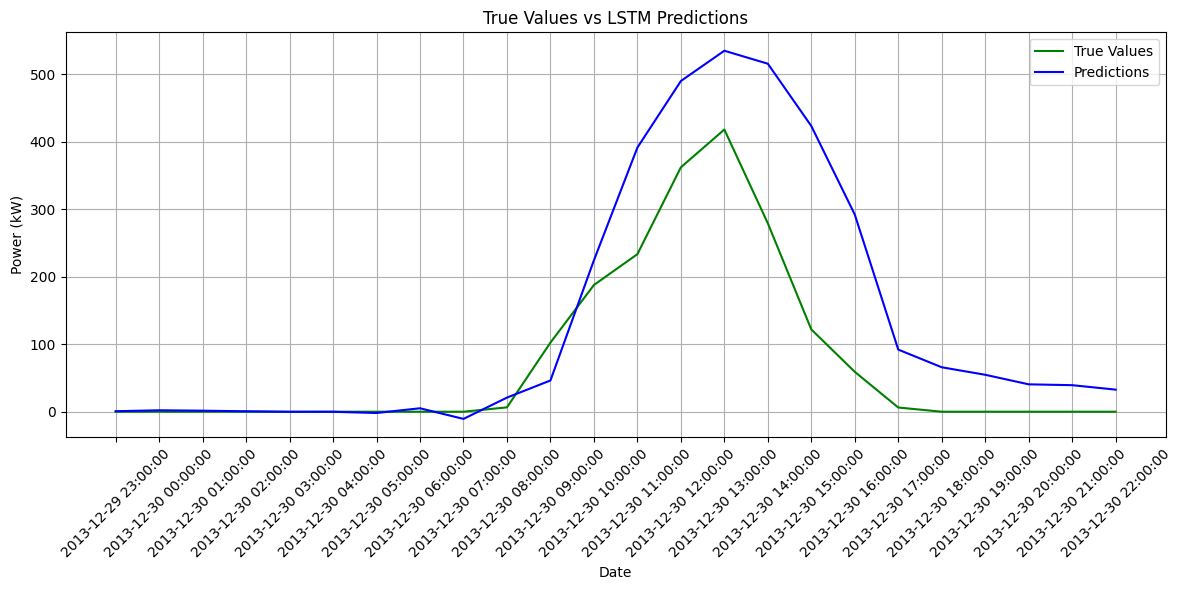

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 107.99607107292144


## GRU 

In [41]:
class GRUNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lstm = nn.GRU(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, (h_t, c_t) = self.lstm(x)
        out = self.fc(x_[:, -1, :])
        return out

In [42]:
grunet = LSTMNet(input_size, hidden_size, num_classes).to(device)
grunet_optimizer = torch.optim.Adam(grunet.parameters(), lr = learning_rate)

In [43]:
total_grunet_parameters = count_parameters(grunet)

In [44]:
grunet_train_loss_array = []
grunet_val_loss_array = []

In [45]:
grunet_start_time = time.time()
train_and_validate(epochs, device, grunet, train_loader, val_loader, criterion, grunet_optimizer, grunet_train_loss_array, grunet_val_loss_array)
grunet_end_time = time.time()
grunet_total_training_time = grunet_end_time - grunet_start_time
grunet_avg_training_time_per_epoch = grunet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 84215.64369032119 | Validation Loss: 25393.175689697266
Epoch no.: 2 | Training Loss: 78931.88530815972 | Validation Loss: 23502.274688720703
Epoch no.: 3 | Training Loss: 74989.03168402778 | Validation Loss: 21772.57440185547
Epoch no.: 4 | Training Loss: 70855.81586371528 | Validation Loss: 19936.009246826172
Epoch no.: 5 | Training Loss: 66891.36360677083 | Validation Loss: 18074.035385131836
Epoch no.: 6 | Training Loss: 62723.41935221354 | Validation Loss: 16511.722412109375
Epoch no.: 7 | Training Loss: 59203.13629828559 | Validation Loss: 15699.493682861328
Epoch no.: 8 | Training Loss: 55631.47497558594 | Validation Loss: 13833.791046142578
Epoch no.: 9 | Training Loss: 52468.46290418837 | Validation Loss: 12619.874069213867
Epoch no.: 10 | Training Loss: 49803.675401475695 | Validation Loss: 11948.609085083008
Epoch no.: 11 | Training Loss: 46937.55160861545 | Validation Loss: 10788.529197692871
Epoch no.: 12 | Training Loss: 44071.56373426649 | V

In [46]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     GRU: {total_grunet_parameters}")
print()
print(f"Total Training Time:     GRU: {grunet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     GRU: {grunet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     GRU: 41301

Total Training Time:     GRU: 166.82s

Average Training Time Per Epoch:     GRU: 0.83s
------------------------------------------------------------


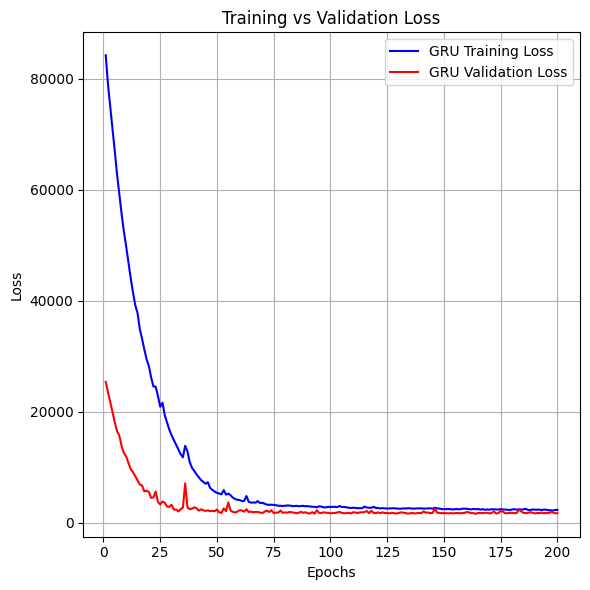

In [47]:
plot_loss_comparison(epochs, grunet_train_loss_array, grunet_val_loss_array, "GRU Training Loss", "GRU Validation Loss", "Training vs Validation Loss")

In [48]:
grunet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = grunet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_3436\1542476720.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


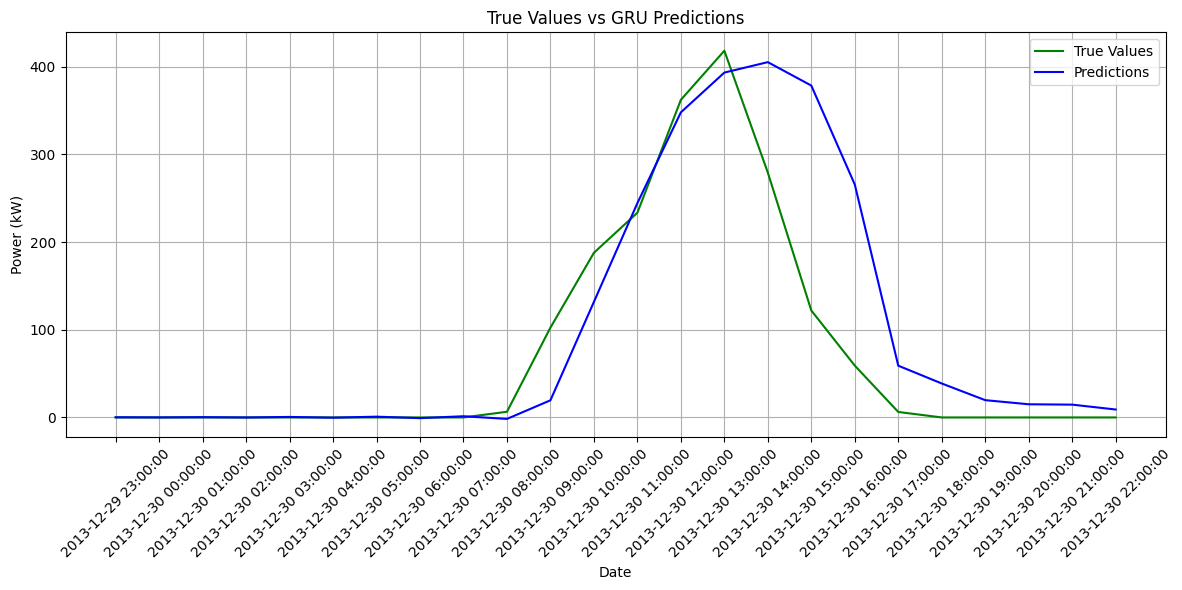

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs GRU Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 76.524891911268
